# Demo 3: diffraction pattern from uniform square

In this manual test, we calculate the diffraction pattern coming from a square uniform current distribution.
From theory, this diffraction pattern should have the following representation:
$$
I_\mathrm{square} = I_0 \mathrm{sinc}^2\left( \frac{\pi L x}{\lambda D} \right) \mathrm{sinc}^2\left( \frac{\pi L y}{\lambda D} \right),
$$
with $I_0$ the initial intensity, $L$ the length of a side of the square, $x$ the x co-ordinate on the detector screen and $y$ the y co-ordinate on the detector screen. The sinc function is defined as $\mathrm{sinc}(x) = \frac{\sin(x)}{x}$.

2025-10-07 13:58:23 - WARNING - System override set to True. 
2025-10-07 13:58:23 - INFO - Added plane square to system. 
2025-10-07 13:58:23 - INFO - Added plane detector to system. 
2025-10-07 13:58:23 - INFO - Translated element detector by ('0.000e+00', '0.000e+00', '1.000e+03') millimeters. 
2025-10-07 13:58:23 - WORK - *** Starting PO propagation *** 
2025-10-07 13:58:23 - WORK - Propagating source on square to detector, propagation mode: EH. 
2025-10-07 13:58:23 - WORK - Hardware: running 256 CUDA threads per block. 
2025-10-07 13:58:23 - WORK - ... Calculating ... 
2025-10-07 13:58:23 - WORK - *** Finished: 0.323 seconds *** 


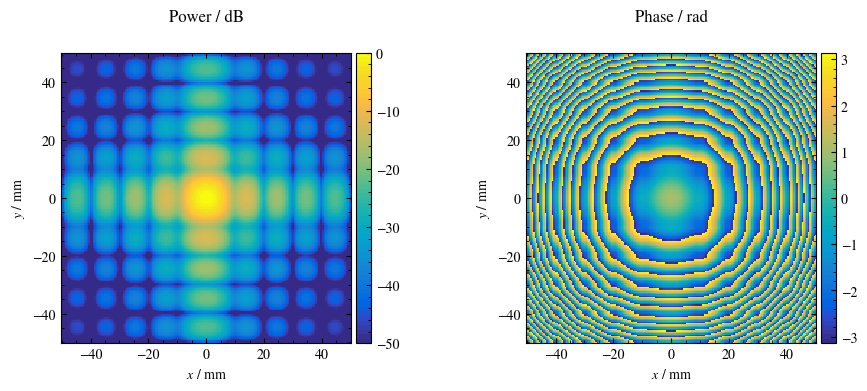

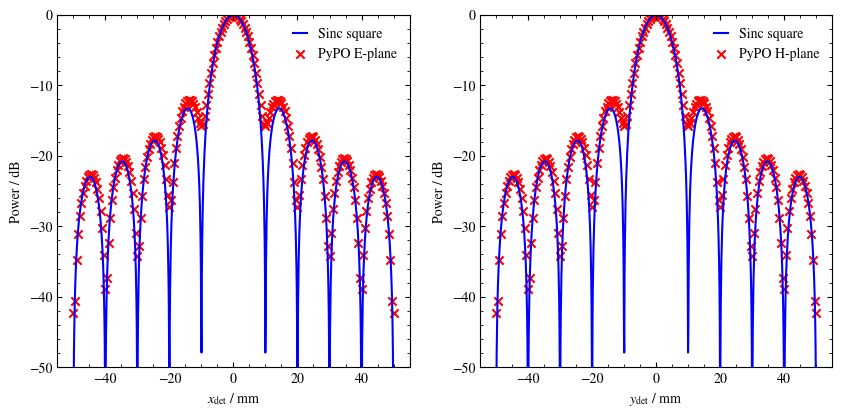

In [1]:
#%matplotlib notebook # Uncomment for interactive plots when running the notebook!
import numpy as np

from scipy.special import sinc 
from pathlib import Path
from PyPO.System import System
from PyPO.Enums import FieldComponents, Modes, Scales

import matplotlib.pyplot as pt

s = System()

# Setting up parameters for defining simulation.

# Source parameters and distances
lam = 0.1               # Wavelength of light in mm
l2_sq = 5               # Half-length of side of square in mm
D = 4 * l2_sq**2 / lam  # Distance between square and screen. 
                        # We choose Fraunhofer distance times four for this simulation.
# Target parameters
lims = 50           # Limits in x and y, in mm

# Setting up surface dictionaries and source current distributions.
square = {
        "name"      : "square",
        "gmode"     : "xy",
        "lims_x"    : np.array([-l2_sq, l2_sq]),
        "lims_y"    : np.array([-l2_sq, l2_sq]),
        "gridsize"  : np.array([201, 201])
        }

detector = {
        "name"      : "detector",
        "gmode"     : "xy",
        "lims_x"   : np.array([-lims, lims]),
        "lims_y"   : np.array([-lims, lims]),
        "gridsize"  : np.array([201, 201])
        }

UDict = {
        "name"      : "source",
        "lam"       : lam
        }

# Add all stuff and translate detector plane to a distance D above the square.
s.addPlane(square)
s.addPlane(detector)
s.translateGrids("detector", np.array([0, 0, D]))

s.createUniformSource(UDict, "square")

# Setting up physical optics propagation
source_to_detector = {
        "s_current"    : "source",
        "t_name"        : "detector",
        "name_EH"       : "EH_detector",
        "mode"          : "EH",
        "epsilon"       : 10,
        }

s.runPO(source_to_detector)

s.plotBeam2D("EH_detector", FieldComponents.Ex, vmin=-50)

# Extract field cuts and corresponding x and y ranges. Note we want cross-sections in decibels.
E, H, x, y = s.calcBeamCuts("EH_detector", FieldComponents.Ex, center=False, align=False, scale=Scales.dB)

# Make finer x and y arrays for generating sinc function.
x_fine = np.linspace(x[0], x[-1], 1000)
y_fine = np.linspace(y[0], y[-1], 1000)

x_sinc = 2 * l2_sq * x_fine / lam / D
y_sinc = 2 * l2_sq * y_fine / lam / D

# Note that we convert the sinc pattern to decibels. 
# This is good for seeing differences on small power scales.
# Need to be careful here as well: sinc in scipy is defined as sinc(x) = sin(pi * x) / (pi * x)
sinc_x_dB = 20 * np.log10(np.absolute(sinc(x_sinc)))
sinc_y_dB = 20 * np.log10(np.absolute(sinc(y_sinc)))

# Plot all the stuff
fig, ax = pt.subplots(1,2, figsize=(10,5))
ax[0].plot(x_fine, sinc_x_dB, color="blue", label="Sinc square")
ax[0].scatter(x, E, marker="x", color="red", label="PyPO E-plane")
ax[0].set_ylim(-50, 0)
ax[0].legend(frameon=False, prop={'size': 10},handlelength=1)
ax[0].set_box_aspect(1)
ax[0].set_xlabel(r"$x_\mathrm{det}$ / mm")
ax[0].set_ylabel("Power / dB")

ax[1].plot(y_fine, sinc_y_dB, color="blue", label="Sinc square")
ax[1].scatter(y, H, marker="x", color="red", label="PyPO H-plane")
ax[1].set_ylim(-50, 0)
ax[1].legend(frameon=False, prop={'size': 10},handlelength=1)
ax[1].set_xlabel(r"$y_\mathrm{det}$ / mm")
ax[1].set_ylabel("Power / dB")
ax[1].set_box_aspect(1)

pt.show()

The beam pattern on the detector screen shows the diffraction pattern coming from a square current distribution.

The cross sections in the lower panel show again nice agreement between theory and the `PyPO` simulation.